In [6]:
#Using imput data of three body motion, trains neural network to predict
#the positions of the bodies at a given time using initial positions
#By Luca Lavezzo, Brandon Manley, Jan. 2020

import pandas as pd
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from itertools import repeat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
import keras.backend as K


dataDir = "/mnt/c/users/llave/Downloads/"
workDir = "/mnt/c/users/llave/Documents/nBody/"

#Import data
df = pd.read_csv(dataDir + "brutus10_1_2.csv")
print(df.shape)

dfShuffle = shuffle(df,random_state=42)

i_col = ["m1","m2", "x1", "x2", "y1", "y2",
		"dx1","dx2","dy1","dy2","t"]

o_col = ["xf1", "xf2", "yf1", "yf2",
		"dxf1", "dxf2", "dyf1", "dyf2"]

X1 = dfShuffle.as_matrix(columns=i_col)
y1 = dfShuffle.as_matrix(columns=o_col)

X_train,X_test,y_train,y_test = train_test_split(X1,y1, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

print(y_train.shape,y_test.shape)

(456882, 22)
(365505, 11) (365505, 8)
(91377, 11) (91377, 8)
(365505, 8) (91377, 8)


/home/llavezzo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/llavezzo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [7]:
print(X_test[0,:],y_train[0,:])

[ 4.47545036e+00  9.51607333e+01  8.61285800e+00 -6.09992100e+00
  3.80188200e+00 -7.27750000e-02  7.73708000e-01  5.80395000e-01
  9.06899000e-01 -3.77925000e-01  5.89843750e+00] [-9.69526083 -4.22247655  6.79367883 -8.01974512 -0.04081577 -0.64698426
  0.02278551  0.31391364]



Train on 365505 samples, validate on 91377 samples
Epoch 1/10
365505/365505 [==============================] - 3s 9us/step - loss: 4.1219 - accuracy: 0.7271 - val_loss: 2.6122 - val_accuracy: 0.7721
Epoch 2/10
365505/365505 [==============================] - 3s 9us/step - loss: 2.3006 - accuracy: 0.7948 - val_loss: 2.0545 - val_accuracy: 0.8092
Epoch 3/10
365505/365505 [==============================] - 3s 8us/step - loss: 2.0046 - accuracy: 0.8158 - val_loss: 1.9089 - val_accuracy: 0.8266
Epoch 4/10
365505/365505 [==============================] - 3s 9us/step - loss: 1.8677 - accuracy: 0.8302 - val_loss: 1.7941 - val_accuracy: 0.8351
Epoch 5/10
365505/365505 [==============================] - 4s 11us/step - loss: 1.7736 - accuracy: 0.8390 - val_loss: 1.8241 - val_accuracy: 0.8334
Epoch 6/10
365505/365505 [==============================] - 4s 11us/step - loss: 1.7138 - accuracy: 0.8464 - val_loss: 1.6642 - val_accuracy: 0.8476
Epoch 7/10
365505/365505 [==============================] 

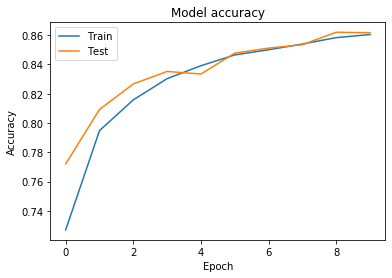

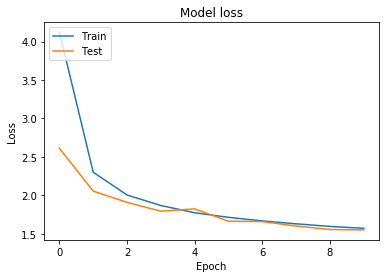

In [8]:
def modified_mse(y_true,y_pred): # FIXME: Update for 2 bodies

	masses = y_true[:, 2]

	#initial positions
	p0 = y_true[:, 3:8] 

	#final positions and velocities
	y_true = y_true[:,10:]

	#predicted final positions and velocities
	p1 = y_pred

	#mean squared error between predicted and true
	mse = K.mean(K.square(y_pred-y_true),axis=-1)

	#intial and final CM, delta
	cm_x_i = (masses[0]*p0[0]+masses[1]*p0[1]+masses[2]*p0[2])/(masses[0]+masses[1]+masses[2])
	cm_y_i = (masses[0]*p0[3]+masses[1]*p0[4]+masses[2]*p0[4])/(masses[0]+masses[1]+masses[2])
	cm_x_f = (masses[0]*p1[0]+masses[1]*p1[1]+masses[2]*p1[2])/(masses[0]+masses[1]+masses[2])
	cm_y_f = (masses[0]*p1[3]+masses[1]*p1[4]+masses[2]*p1[4])/(masses[0]+masses[1]+masses[2])
	delta_cm_x = abs(cm_x_i-cm_x_f)
	delta_cm_y = abs(cm_y_i-cm_y_f)

	return mse



#parameters 
max_epochs = 10
optimizer = 'adam'
batch_size = 1000         #FIXME: paper used 5000 for 10000 events

network = models.Sequential()
network.add(layers.Dense(128,activation='relu',input_dim=11))
for i in range(5):
	network.add(layers.Dense(128,activation='relu'))
network.add(layers.Dense(8,activation='linear'))
network.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
network.save_weights(workDir + '/weights/model_init.h5')

history = network.fit(X_train,y_train,
                              epochs=max_epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,y_test),
                              verbose = 1)

training_vals_acc = history.history['accuracy']
training_vals_loss = history.history['loss']
valid_vals_acc = history.history['val_accuracy']
valid_vals_loss = history.history['val_loss']
iterations = len(training_vals_acc)
print("Number of iterations:",iterations)
print("Epoch\t Train Loss\t Train Acc\t Val Loss\t Val Acc")
i = 0
for tl,ta,vl,va in zip(training_vals_loss,training_vals_acc,valid_vals_loss,valid_vals_acc):
    print(i,'\t',round(tl,5),'\t',round(ta,5),'\t',round(vl,5),'\t',round(va,5))
    i += 1

# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(workDir + 'model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(workDir + 'model_loss.png')
plt.show()

In [9]:
X_test[0,:]    

array([ 4.47545036e+00,  9.51607333e+01,  8.61285800e+00, -6.09992100e+00,
        3.80188200e+00, -7.27750000e-02,  7.73708000e-01,  5.80395000e-01,
        9.06899000e-01, -3.77925000e-01,  5.89843750e+00])

In [10]:
print(np.asarray(X_test[0,:]).T.shape)
print(network.predict( np.array( [X_test[0,:],] )  ))

(11,)
[[ 7.162414   -2.4917095   5.9618173  -1.9764593  -1.1755188   0.74451053
  -0.458627    0.16062987]]
